In [1]:
from utils import *
from dataset import *
from constants import *
from models.BaseModels import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from dataset import Participant

random.seed(RANDOM_STATE)

In [2]:
use_saved = False
part_name = 's6'

In [3]:
if use_saved:
    participant = Participant.load_from_pickle(f'saved/{part_name}.pkl')
else:
    participant = Participant(part_name, data_path=DATA_PATH_NOTEBOOK, alpha=0.05)
    with open(f'saved/{part_name}.pkl', 'wb') as f:
        pickle.dump(participant, f, pickle.HIGHEST_PROTOCOL)

In [5]:
test_size = 0.3
pca_expl_var = 0.95

## Execution

In [6]:
set_bigsmall = set(participant.relevant_channels_bigsmall)
set_exobs = set(participant.relevant_channels_both)

list_uniquely_responsive_to_only_bigsmall = list(set_bigsmall ^ set_exobs)

In [7]:
ex_features_dict = {}

for channel_idx in range(len(participant.relevant_channels_bigsmall)):
    ex_features_dict[channel_idx] = participant.new_get_features_all_sessions_mvt('E', channels=[channel_idx])

  0%|          | 0/256 [00:00<?, ?it/s]

100%|██████████| 256/256 [00:11<00:00, 23.08it/s]


In [8]:
logreg_accuracies = []
logreg_pca_accuracies = []
svm_accuracies = []
svm_pca_accuracies = []
rf_accuracies = []

y = ex_features_dict[0]['label']
for top_channels in range(1, len(participant.relevant_channels_bigsmall)+1):
    ex_features = pd.concat([ex_features_dict[i].drop('label', axis=1) for i in range(top_channels)], axis=1)
    print(f'The dataset contains {ex_features.shape[0]} samples and {ex_features.shape[1]} features.')
    print(f'The {len(participant.relevant_channels_bigsmall[:top_channels])} most relevant channels are located in the following locations:')
    regions = [participant.channels_locations[i] for i in [channel.idx for channel in participant.relevant_channels_bigsmall[:top_channels]]]
    channels_per_regions = {}
    for region in set(regions):
        channels_per_regions[region] = regions.count(region)
    print(channels_per_regions)

    X_train, X_test, y_train, y_test = train_test_split(ex_features, y, test_size=test_size, random_state=RANDOM_STATE)
    logreg = LogisticRegressionModel()
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    logreg_accuracies.append(accuracy)
    print(f"LogReg Accuracy: {accuracy:.2f}")
    logreg = LogisticRegressionModel(use_pca=True, expl_var=0.95)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    logreg_pca_accuracies.append(accuracy)
    print(f"LogReg PCA Accuracy: {accuracy:.2f}")
    svm = SVMModel()
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    svm_accuracies.append(accuracy)
    print(f"SVM Accuracy: {accuracy:.2f}")
    svm = SVMModel(use_pca=True, expl_var=0.95)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    svm_pca_accuracies.append(accuracy)
    print(f"SVM PCA Accuracy: {accuracy:.2f}")
    svm = RandomForestModel()
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    rf_accuracies.append(accuracy)
    print(f"RF Accuracy: {accuracy:.2f}")

The dataset contains 128 samples and 72 features.
The 1 most relevant channels are located in the following locations:
{'postcentral': 1}
LogReg Accuracy: 0.54
LogReg PCA Accuracy: 0.51
SVM Accuracy: 0.41
SVM PCA Accuracy: 0.41
RF Accuracy: 0.44
The dataset contains 128 samples and 144 features.
The 2 most relevant channels are located in the following locations:
{'postcentral': 1, 'precentral': 1}
LogReg Accuracy: 0.59
LogReg PCA Accuracy: 0.49
SVM Accuracy: 0.49
SVM PCA Accuracy: 0.49
RF Accuracy: 0.49
The dataset contains 128 samples and 216 features.
The 3 most relevant channels are located in the following locations:
{'postcentral': 1, 'precentral': 2}
LogReg Accuracy: 0.46
LogReg PCA Accuracy: 0.51
SVM Accuracy: 0.54
SVM PCA Accuracy: 0.54
RF Accuracy: 0.41
The dataset contains 128 samples and 288 features.
The 4 most relevant channels are located in the following locations:
{'WM_precentral': 1, 'postcentral': 1, 'precentral': 2}
LogReg Accuracy: 0.49
LogReg PCA Accuracy: 0.51
SV

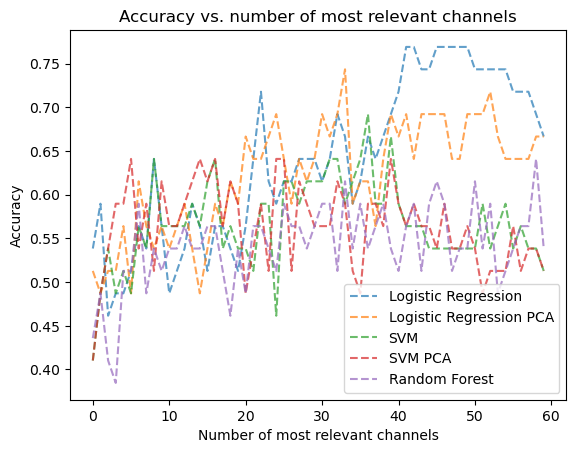

In [9]:
plt.plot(logreg_accuracies, '--', alpha=0.7, label='Logistic Regression')
plt.plot(logreg_pca_accuracies, '--', alpha=0.7, label='Logistic Regression PCA')
plt.plot(svm_accuracies, '--', alpha=0.7, label='SVM')
plt.plot(svm_pca_accuracies, '--', alpha=0.7, label='SVM PCA')
plt.plot(rf_accuracies, '--', alpha=0.7, label='Random Forest')
plt.legend()
plt.xlabel('Number of most relevant channels')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. number of most relevant channels')
plt.show()